## Problem 7.1: Hacker stats and Darwin's finches

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st

import pystan

import bebi103

import altair as alt
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

a) We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.

In [3]:
# Read in the data
df = pd.read_csv('../data/finch_beaks.csv', comment='#')

# Take a look
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


Let's look for duplicates based on band number and year.

In [10]:
pd.concat(g for _, g in df.groupby(['band', 'year']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
304,818,fortis,10.2,9.00,1975
305,818,fortis,10.2,9.00,1975
363,944,fortis,10.3,8.30,1975
364,944,fortis,10.3,8.30,1975
365,945,fortis,11.6,10.80,1975
366,945,fortis,11.6,10.80,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


It looks like for ID 19028, the species was identified as fortis and then as scandens, but the beak measurements are the same. For IDs 818, 944, and 945, the rows are exact duplicates. For band 316, the beak depth measurement is different.

Let's first drop complete duplicates.

In [20]:
df_deduped = df.drop_duplicates()

In [23]:
len(df)

2304

In [22]:
len(df_deduped)

2301

Three rows were indeed deleted.

In [24]:
pd.concat(g for _, g in df_deduped.groupby(['band', 'year']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


In [17]:
df.loc[df['band'] == 19028]

,band,species,beak length (mm),beak depth (mm),year
2057,19028,fortis,12.5,8.9,2012
2178,19028,scandens,12.5,8.9,2012


In [18]:
df.loc[df['band'] == 316]

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975


It makes most sense to delete the row for ID 19028 since we have no idea what species the bird is. For band 316, we could either take the mean of the beak depths or delete this row as well.

Let's delete these rows for now.

In [27]:
df_deduped = df_deduped.drop([2057,2178,102,103])

In [28]:
len(df_deduped)

2297

b) Plot ECDFs of the beak depths of Geospiza scandens in 1975 and in 2012. Then, estimate the mean beak depth in for each of these years with confidence intervals.

Let's plot ECDFs of the beak depths of Geospiza scandens in 1975 and 2012.

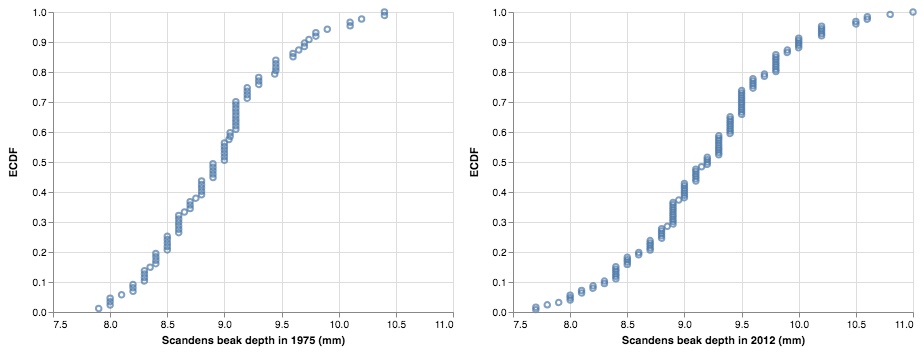

In [41]:
inds_1975 = ((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 1975))
    
inds_2012 = ((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 2012))

p1 = altcat.catplot(data=df_deduped.loc[inds_1975],
                    mark='point',
                    encoding={'x': alt.X('beak depth (mm):Q', 
                                         title='Scandens beak depth in 1975 (mm)', 
                                         scale=alt.Scale(domain=[7.5, 11]))},
                    transform='ecdf')

p2 = altcat.catplot(data=df_deduped.loc[inds_2012],
                    mark='point',
                    encoding={'x': alt.X('beak depth (mm):Q', 
                                         title='Scandens beak depth in 2012 (mm)', 
                                         scale=alt.Scale(domain=[7.5, 11]))},
                    transform='ecdf')

p1 | p2

Now let's estimate the mean beak depth in each of these years.

c) Perform a hypothesis test comparing the G. scandens beak depths in 1975 and 2012. Carefully state your null hypothesis, your test statistic, and your definition of what it means to be at least as extreme as the observed test statistic. Comment on the results. It might be interesting to know that a severe drought in 1976 and 1977 resulted in the death of the plants that produce small seeds on the island.

d) Devise a measure for the shape of a beak. That is, invent some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

e) Introgressive hybridization occurs when a G. scandens bird mates with a G. fortis bird, and then the offspring mates again with pure G. scandens. This brings traits from G. fortis into the G. scandens genome. As this may be a mode by which beak geometries of G. scandens change over time, it is useful to know how heritable a trait is. Heritability is defined as the ratio of the covariance between parents and offsprings to the variance of the parents alone. To be clear, the heritability is defined as follows.

Compute the average value of a trait in a pair of parents.
Compute the average value of that trait among the offspring of those parents.
Do this for each set of parents/offspring. Using this data set, compute the covariance among all average offspring and the variance among all average parents.
This is a more apt definition than, say, the Pearson correlation, because it is a direct comparison between parents and offspring.

Heritability data for beak depth for G. fortis and G. scandens can be found here and here, respectively. (Be sure to look at the files before reading them in; they do have different formats.) From these data, compute the heritability of beak depth in the two species, with confidence intervals. How do they differ, and what consequences might this have for introgressive hybridization?